### Importing Libraries

In [61]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

### Loading the Dataset

In [63]:
train=pd.read_csv("train_data.csv")
test=pd.read_csv("test_data.csv")
variable_description=pd.read_csv("VariableDescription.csv")
sample_submission=pd.read_csv("Submission1.csv")

### Exploring the Data

In [64]:
train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


In [66]:
train.describe(include='all')

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
count,7160,7160.000000,7160.000000,7160.000000,7160,7160,7153,7160,7054.000000,7160.000000,6652.000000,7160,7058,7160.000000
unique,7160,NaN,NaN,NaN,2,2,2,2,NaN,NaN,NaN,11,1307,NaN
top,H1810,NaN,NaN,NaN,V,N,O,R,NaN,NaN,NaN,.,6088,NaN
freq,1,NaN,NaN,NaN,5382,3608,3602,3610,NaN,NaN,NaN,3551,143,NaN
mean,NaN,2013.669553,0.909758,0.305447,NaN,NaN,NaN,NaN,1883.727530,2.186034,1964.456404,NaN,NaN,0.228212
std,NaN,1.383769,0.239756,0.460629,NaN,NaN,NaN,NaN,2278.157745,0.940632,36.002014,NaN,NaN,0.419709
min,NaN,2012.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1545.000000,NaN,NaN,0.000000
25%,NaN,2012.000000,0.997268,0.000000,NaN,NaN,NaN,NaN,528.000000,2.000000,1960.000000,NaN,NaN,0.000000
50%,NaN,2013.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,1083.000000,2.000000,1970.000000,NaN,NaN,0.000000
75%,NaN,2015.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,2289.750000,3.000000,1980.000000,NaN,NaN,0.000000


In [67]:
train.shape

(7160, 14)

In [68]:
train.NumberOfWindows.value_counts() #You might need to remove!

   .    3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: NumberOfWindows, dtype: int64

In [69]:
train.Building_Type.value_counts()

2    3305
1    1716
3    1230
4     909
Name: Building_Type, dtype: int64

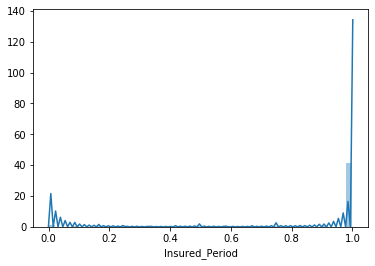

In [70]:
sns.distplot(train.Insured_Period)

In [71]:
train.Settlement.value_counts()

R    3610
U    3550
Name: Settlement, dtype: int64

In [72]:
train.Building_Painted.value_counts()

V    5382
N    1778
Name: Building_Painted, dtype: int64

In [73]:
train.Building_Fenced.value_counts()

N    3608
V    3552
Name: Building_Fenced, dtype: int64

In [74]:
train.Garden.value_counts()

O    3602
V    3551
Name: Garden, dtype: int64

In [75]:
train['YearOfObservation'].value_counts()

2012    1858
2013    1811
2014    1373
2015    1075
2016    1043
Name: YearOfObservation, dtype: int64

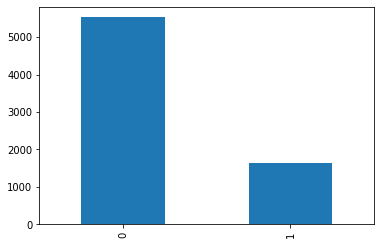

In [76]:
train.Claim.value_counts().plot.bar()

In [77]:
train.dtypes

Customer Id            object
YearOfObservation       int64
Insured_Period        float64
Residential             int64
Building_Painted       object
Building_Fenced        object
Garden                 object
Settlement             object
Building Dimension    float64
Building_Type           int64
Date_of_Occupancy     float64
NumberOfWindows        object
Geo_Code               object
Claim                   int64
dtype: object

In [78]:
variable_description

,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


In [79]:
train.columns

Index(['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code', 'Claim'],
      dtype='object')

In [80]:
test.columns

Index(['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code'],
      dtype='object')

In [81]:
train.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [82]:
test.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  4
Settlement              0
Building Dimension     13
Building_Type           0
Date_of_Occupancy     728
NumberOfWindows         0
Geo_Code               13
dtype: int64

### Data Preparation

In [83]:
#Checking for Duplicates in Data
print (train.duplicated().sum())
print (test.duplicated().sum())

0
0


In [84]:
train['Building Dimension']=train['Building Dimension'].fillna(train['Building Dimension'].median())
train['Garden']=train['Garden'].fillna('O')
train['Date_of_Occupancy']=train['Date_of_Occupancy'].fillna(1970.0)

In [85]:
test['Building Dimension']=test['Building Dimension'].fillna(test['Building Dimension'].median())
test['Garden']=test['Garden'].fillna('V')
test['Date_of_Occupancy']=test['Date_of_Occupancy'].fillna(1960.0)

In [86]:
train=train.drop(['Geo_Code'],1)
test=test.drop(['Geo_Code'],1)

In [87]:
train=train.drop(['YearOfObservation','Date_of_Occupancy', 'NumberOfWindows'],1)
test=test.drop(['YearOfObservation','Date_of_Occupancy','NumberOfWindows'],1)

In [88]:
train['Residential']=train['Residential'].astype('category')
train['Building_Painted']=train['Building_Painted'].astype('category')
train['Building_Fenced']=train['Building_Fenced'].astype('category')
train['Garden']=train['Garden'].astype('category')
train['Settlement']=train['Settlement'].astype('category')
train['Building_Type']=train['Building_Type'].astype('category')

In [89]:
test['Residential']=test['Residential'].astype('category')
test['Building_Painted']=test['Building_Painted'].astype('category')
test['Building_Fenced']=test['Building_Fenced'].astype('category')
test['Garden']=test['Garden'].astype('category')
test['Settlement']=test['Settlement'].astype('category')
test['Building_Type']=test['Building_Type'].astype('category')

In [90]:
train.dtypes

Customer Id             object
Insured_Period         float64
Residential           category
Building_Painted      category
Building_Fenced       category
Garden                category
Settlement            category
Building Dimension     float64
Building_Type         category
Claim                    int64
dtype: object

In [91]:
Categorical_Data=train[['Residential','Building_Painted','Building_Fenced','Garden','Settlement','Building_Type']]
Categorical_Data_Test=test[['Residential','Building_Painted','Building_Fenced','Garden','Settlement','Building_Type']]

In [92]:
Numerical_Data=train.drop(Categorical_Data,1)

In [93]:
Numerical_Data=Numerical_Data.drop(['Customer Id','Claim'],1)

In [94]:
Numerical_Data_Test=test.drop(Categorical_Data,1)
Numerical_Data_Test=Numerical_Data_Test.drop(['Customer Id'],1)

In [95]:
encoders=ce.TargetEncoder()
Target_Response=train['Claim']
encoders.fit_transform(Categorical_Data,Target_Response)
Categorical_Data=encoders.transform(Categorical_Data)

In [96]:
Categorical_Data_Test=encoders.transform(Categorical_Data_Test)

In [97]:
X=Categorical_Data
X['Insured_Period']=Numerical_Data['Insured_Period']
X['Building Dimension'] = Numerical_Data['Building Dimension']
y=train['Claim']

In [98]:
Test=Categorical_Data_Test
Test['Insured_Period']=Numerical_Data_Test['Insured_Period']
Test['Building Dimension'] = Numerical_Data_Test['Building Dimension']

In [99]:
smote = SMOTE(random_state=10)
X_new, y_new = smote.fit_resample(X,y)
print(X.shape, y.shape)
print(X_new.shape, y_new.shape)

(7160, 8) (7160,)
(11052, 8) (11052,)


### Modelling

In [40]:
X_train,X_test,y_train,y_test=train_test_split(X_new,y_new,test_size=0.33,random_state=42)

#### Linear Regression

In [41]:
model_log=LogisticRegression(C=100, solver='newton-cg')

In [42]:
model_log.fit(X_train,y_train)

LogisticRegression(C=100, solver='newton-cg')

In [43]:
pred=model_log.predict(X_test)

0.6508028635016467


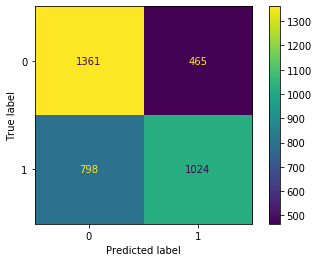

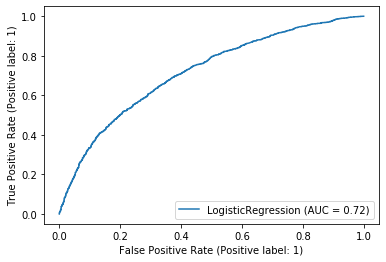

In [44]:
plot_confusion_matrix(model_log,X_test, y_test)
metrics.plot_roc_curve(model_log, X_test, y_test)
print (f1_score(y_test, pred, average='macro'))
plt.show()

In [116]:
prediction1=model_log.predict(Test)
identity=test['Customer Id']

Prediction=pd.DataFrame(prediction1,identity)
Prediction.columns=['Claim']

Prediction.to_csv("prediction1.csv")

0.6350375931229901


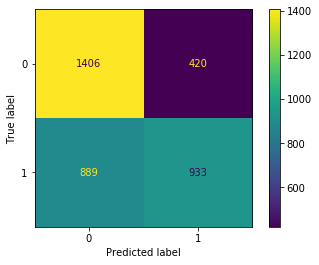

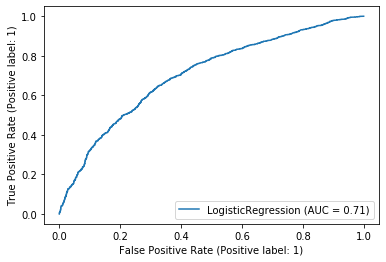

In [45]:
model_log_2=LogisticRegression()
model_log_2.fit(X_train,y_train)
pred=model_log_2.predict(X_test)
plot_confusion_matrix(model_log_2,X_test, y_test)
metrics.plot_roc_curve(model_log_2, X_test, y_test)
print (f1_score(y_test, pred, average='macro'))
plt.show()

In [118]:
prediction2=model_log_2.predict(Test)
identity=test['Customer Id']

Prediction=pd.DataFrame(prediction2,identity)
Prediction.columns=['Claim']

Prediction.to_csv("prediction2.csv")

####  Radom Forest Classifiers

In [57]:
model_forest=RandomForestClassifier()

In [58]:
model_forest.fit(X_train,y_train)

RandomForestClassifier()

In [59]:
pred=model_forest.predict(X_test)

0.8077670949479072


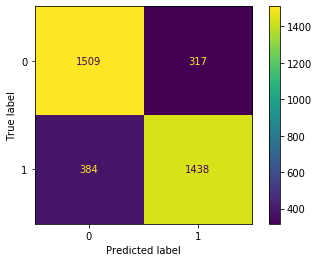

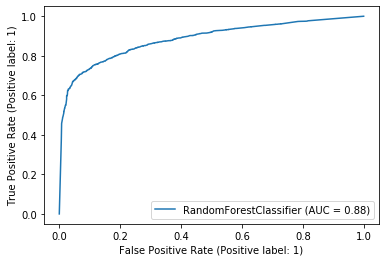

In [60]:
plot_confusion_matrix(model_forest,X_test, y_test)
metrics.plot_roc_curve(model_forest, X_test, y_test)
print (f1_score(y_test, pred, average='macro'))
plt.show()

In [123]:
prediction3=model_forest.predict(Test)
identity=test['Customer Id']

Prediction=pd.DataFrame(prediction3,identity)
Prediction.columns=['Claim']

Prediction.to_csv("prediction3.csv")

#### XGB Classifier

0.8280888467038876


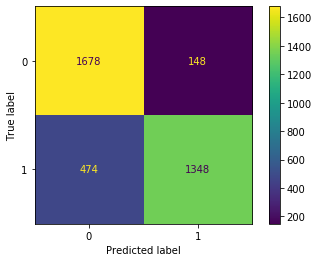

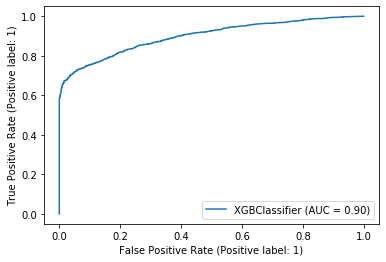

In [125]:
xgb=XGBClassifier()

xgb.fit(X_train,y_train)

pred=xgb.predict(X_test)

plot_confusion_matrix(xgb,X_test, y_test)
metrics.plot_roc_curve(xgb, X_test, y_test)
print (f1_score(y_test, pred, average='macro'))
plt.show()

In [126]:
prediction4=xgb.predict(Test)
identity=test['Customer Id']

Prediction=pd.DataFrame(prediction4,identity)
Prediction.columns=['Claim']

Prediction.to_csv("prediction4.csv")

#### CatBoost Classifier

Learning rate set to 0.024221
0:	learn: 0.6771901	total: 23.5ms	remaining: 23.5s
1:	learn: 0.6626170	total: 32.7ms	remaining: 16.3s
2:	learn: 0.6468433	total: 41.6ms	remaining: 13.8s
3:	learn: 0.6346931	total: 50.6ms	remaining: 12.6s
4:	learn: 0.6229723	total: 59.5ms	remaining: 11.8s
5:	learn: 0.6103396	total: 68.4ms	remaining: 11.3s
6:	learn: 0.6014679	total: 78.3ms	remaining: 11.1s
7:	learn: 0.5919152	total: 87.2ms	remaining: 10.8s
8:	learn: 0.5830286	total: 96.1ms	remaining: 10.6s
9:	learn: 0.5747590	total: 105ms	remaining: 10.4s
10:	learn: 0.5673109	total: 114ms	remaining: 10.2s
11:	learn: 0.5586439	total: 123ms	remaining: 10.1s
12:	learn: 0.5523420	total: 132ms	remaining: 10s
13:	learn: 0.5453802	total: 141ms	remaining: 9.9s
14:	learn: 0.5379657	total: 150ms	remaining: 9.82s
15:	learn: 0.5323417	total: 161ms	remaining: 9.91s
16:	learn: 0.5262904	total: 173ms	remaining: 9.99s
17:	learn: 0.5201682	total: 185ms	remaining: 10.1s
18:	learn: 0.5172472	total: 195ms	remaining: 10.1s
19:	l

165:	learn: 0.3772143	total: 1.73s	remaining: 8.71s
166:	learn: 0.3767884	total: 1.75s	remaining: 8.71s
167:	learn: 0.3764892	total: 1.76s	remaining: 8.7s
168:	learn: 0.3761510	total: 1.77s	remaining: 8.69s
169:	learn: 0.3758916	total: 1.78s	remaining: 8.68s
170:	learn: 0.3757889	total: 1.79s	remaining: 8.66s
171:	learn: 0.3756362	total: 1.79s	remaining: 8.64s
172:	learn: 0.3755141	total: 1.8s	remaining: 8.63s
173:	learn: 0.3752487	total: 1.81s	remaining: 8.61s
174:	learn: 0.3751369	total: 1.82s	remaining: 8.59s
175:	learn: 0.3750441	total: 1.83s	remaining: 8.57s
176:	learn: 0.3749206	total: 1.84s	remaining: 8.55s
177:	learn: 0.3746104	total: 1.85s	remaining: 8.54s
178:	learn: 0.3745270	total: 1.86s	remaining: 8.52s
179:	learn: 0.3744154	total: 1.87s	remaining: 8.5s
180:	learn: 0.3741780	total: 1.88s	remaining: 8.49s
181:	learn: 0.3740548	total: 1.89s	remaining: 8.47s
182:	learn: 0.3739665	total: 1.89s	remaining: 8.46s
183:	learn: 0.3735315	total: 1.9s	remaining: 8.44s
184:	learn: 0.37

329:	learn: 0.3553433	total: 3.29s	remaining: 6.68s
330:	learn: 0.3552522	total: 3.3s	remaining: 6.68s
331:	learn: 0.3551462	total: 3.31s	remaining: 6.67s
332:	learn: 0.3550328	total: 3.33s	remaining: 6.66s
333:	learn: 0.3548367	total: 3.34s	remaining: 6.65s
334:	learn: 0.3548004	total: 3.35s	remaining: 6.64s
335:	learn: 0.3546748	total: 3.35s	remaining: 6.63s
336:	learn: 0.3545858	total: 3.36s	remaining: 6.62s
337:	learn: 0.3545023	total: 3.37s	remaining: 6.61s
338:	learn: 0.3544429	total: 3.38s	remaining: 6.59s
339:	learn: 0.3543546	total: 3.39s	remaining: 6.58s
340:	learn: 0.3542221	total: 3.4s	remaining: 6.57s
341:	learn: 0.3541890	total: 3.41s	remaining: 6.56s
342:	learn: 0.3541115	total: 3.42s	remaining: 6.55s
343:	learn: 0.3539530	total: 3.43s	remaining: 6.53s
344:	learn: 0.3538924	total: 3.44s	remaining: 6.52s
345:	learn: 0.3538092	total: 3.44s	remaining: 6.51s
346:	learn: 0.3537444	total: 3.45s	remaining: 6.5s
347:	learn: 0.3536072	total: 3.46s	remaining: 6.49s
348:	learn: 0.3

488:	learn: 0.3377971	total: 4.84s	remaining: 5.06s
489:	learn: 0.3377001	total: 4.85s	remaining: 5.05s
490:	learn: 0.3375474	total: 4.86s	remaining: 5.04s
491:	learn: 0.3374799	total: 4.87s	remaining: 5.03s
492:	learn: 0.3374177	total: 4.88s	remaining: 5.02s
493:	learn: 0.3373359	total: 4.89s	remaining: 5.01s
494:	learn: 0.3371915	total: 4.9s	remaining: 5s
495:	learn: 0.3371368	total: 4.91s	remaining: 4.99s
496:	learn: 0.3370829	total: 4.92s	remaining: 4.98s
497:	learn: 0.3369012	total: 4.93s	remaining: 4.97s
498:	learn: 0.3368160	total: 4.94s	remaining: 4.96s
499:	learn: 0.3367606	total: 4.95s	remaining: 4.95s
500:	learn: 0.3366070	total: 4.96s	remaining: 4.93s
501:	learn: 0.3364647	total: 4.96s	remaining: 4.92s
502:	learn: 0.3363113	total: 4.97s	remaining: 4.91s
503:	learn: 0.3362585	total: 4.98s	remaining: 4.9s
504:	learn: 0.3362006	total: 4.99s	remaining: 4.89s
505:	learn: 0.3360913	total: 5s	remaining: 4.88s
506:	learn: 0.3360362	total: 5.01s	remaining: 4.87s
507:	learn: 0.335898

653:	learn: 0.3242205	total: 6.39s	remaining: 3.38s
654:	learn: 0.3241940	total: 6.41s	remaining: 3.37s
655:	learn: 0.3241262	total: 6.42s	remaining: 3.37s
656:	learn: 0.3240303	total: 6.43s	remaining: 3.36s
657:	learn: 0.3240029	total: 6.44s	remaining: 3.35s
658:	learn: 0.3239368	total: 6.45s	remaining: 3.34s
659:	learn: 0.3238904	total: 6.46s	remaining: 3.33s
660:	learn: 0.3238344	total: 6.47s	remaining: 3.32s
661:	learn: 0.3237725	total: 6.47s	remaining: 3.31s
662:	learn: 0.3236766	total: 6.48s	remaining: 3.3s
663:	learn: 0.3236295	total: 6.49s	remaining: 3.29s
664:	learn: 0.3235967	total: 6.5s	remaining: 3.27s
665:	learn: 0.3235468	total: 6.51s	remaining: 3.27s
666:	learn: 0.3235002	total: 6.52s	remaining: 3.25s
667:	learn: 0.3234232	total: 6.53s	remaining: 3.24s
668:	learn: 0.3233530	total: 6.54s	remaining: 3.23s
669:	learn: 0.3232863	total: 6.55s	remaining: 3.22s
670:	learn: 0.3231990	total: 6.55s	remaining: 3.21s
671:	learn: 0.3230492	total: 6.56s	remaining: 3.2s
672:	learn: 0.3

825:	learn: 0.3136547	total: 8.13s	remaining: 1.71s
826:	learn: 0.3136317	total: 8.14s	remaining: 1.7s
827:	learn: 0.3135666	total: 8.15s	remaining: 1.69s
828:	learn: 0.3135105	total: 8.16s	remaining: 1.68s
829:	learn: 0.3134305	total: 8.17s	remaining: 1.67s
830:	learn: 0.3133574	total: 8.18s	remaining: 1.66s
831:	learn: 0.3132939	total: 8.19s	remaining: 1.65s
832:	learn: 0.3132610	total: 8.2s	remaining: 1.64s
833:	learn: 0.3132073	total: 8.21s	remaining: 1.63s
834:	learn: 0.3131537	total: 8.22s	remaining: 1.62s
835:	learn: 0.3130741	total: 8.23s	remaining: 1.61s
836:	learn: 0.3129937	total: 8.23s	remaining: 1.6s
837:	learn: 0.3129446	total: 8.24s	remaining: 1.59s
838:	learn: 0.3129020	total: 8.25s	remaining: 1.58s
839:	learn: 0.3128615	total: 8.26s	remaining: 1.57s
840:	learn: 0.3127967	total: 8.27s	remaining: 1.56s
841:	learn: 0.3127348	total: 8.28s	remaining: 1.55s
842:	learn: 0.3126495	total: 8.29s	remaining: 1.54s
843:	learn: 0.3125774	total: 8.3s	remaining: 1.53s
844:	learn: 0.31

988:	learn: 0.3049903	total: 9.67s	remaining: 108ms
989:	learn: 0.3049533	total: 9.69s	remaining: 97.8ms
990:	learn: 0.3048912	total: 9.7s	remaining: 88.1ms
991:	learn: 0.3048651	total: 9.71s	remaining: 78.3ms
992:	learn: 0.3048222	total: 9.72s	remaining: 68.5ms
993:	learn: 0.3047523	total: 9.73s	remaining: 58.7ms
994:	learn: 0.3047226	total: 9.73s	remaining: 48.9ms
995:	learn: 0.3046834	total: 9.74s	remaining: 39.1ms
996:	learn: 0.3046611	total: 9.75s	remaining: 29.3ms
997:	learn: 0.3045757	total: 9.76s	remaining: 19.6ms
998:	learn: 0.3045389	total: 9.77s	remaining: 9.78ms
999:	learn: 0.3045088	total: 9.78s	remaining: 0us
0.8256042659207135


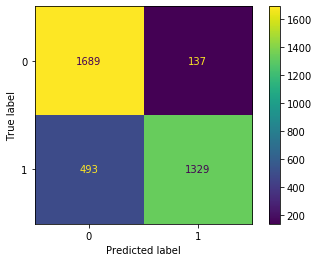

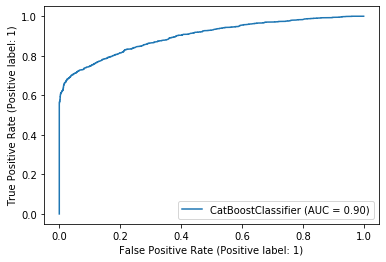

In [132]:
CatBoost=CatBoostClassifier()

CatBoost.fit(X_train,y_train)

pred=CatBoost.predict(X_test)

plot_confusion_matrix(CatBoost,X_test, y_test)
metrics.plot_roc_curve(CatBoost, X_test, y_test)
print (f1_score(y_test, pred, average='macro'))
plt.show()

In [133]:
prediction5=CatBoost.predict(Test)
identity=test['Customer Id']

Prediction=pd.DataFrame(prediction5,identity)
Prediction.columns=['Claim']

Prediction.to_csv("prediction5.csv")

#### Support Vector Classifiers

0.6265877037677672


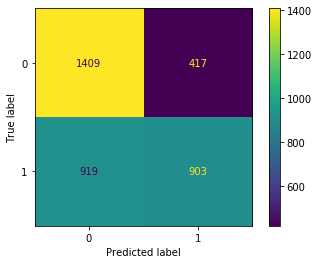

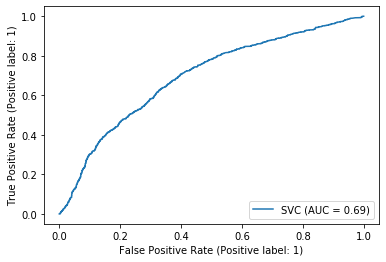

In [134]:
svc=SVC()

svc.fit(X_train,y_train)

pred=svc.predict(X_test)

plot_confusion_matrix(svc,X_test, y_test)
metrics.plot_roc_curve(svc, X_test, y_test)
print (f1_score(y_test, pred, average='macro'))
plt.show()

In [135]:
prediction6=svc.predict(Test)
identity=test['Customer Id']

Prediction=pd.DataFrame(prediction6,identity)
Prediction.columns=['Claim']

Prediction.to_csv("prediction6.csv")

#### Voting Classifier

0.6265877037677672


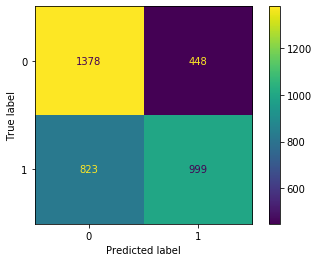

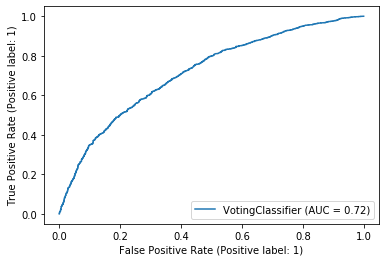

In [145]:
clf1=model_log=LogisticRegression(C=100, solver='newton-cg')
clf2=SVC(probability=True)
Voting=VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],voting='soft', weights=[2,1,1],flatten_transform=True)

Voting.fit(X_train,y_train)

plot_confusion_matrix(Voting,X_test, y_test)
metrics.plot_roc_curve(Voting, X_test, y_test)
print (f1_score(y_test, pred, average='macro'))
plt.show()

In [146]:
prediction7=Voting.predict(Test)
identity=test['Customer Id']

Prediction=pd.DataFrame(prediction7,identity)
Prediction.columns=['Claim']

Prediction.to_csv("prediction7.csv")

In [ ]:
clf1=model_log=LogisticRegression(C=100, solver='newton-cg')
clf2=SVC(probability=True)
Voting=VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)],voting='soft', weights=[2,1],flatten_transform=True)

Voting.fit(X_train,y_train)

plot_confusion_matrix(Voting,X_test, y_test)
metrics.plot_roc_curve(Voting, X_test, y_test)
print (f1_score(y_test, pred, average='macro'))
plt.show()

In [ ]:
prediction8=Voting.predict(Test)
identity=test['Customer Id']

Prediction=pd.DataFrame(prediction8,identity)
Prediction.columns=['Claim']

Prediction.to_csv("prediction8.csv")

0.6265877037677672


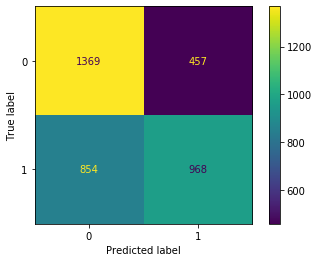

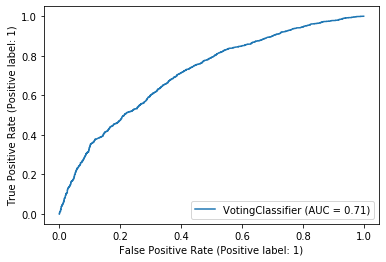

In [147]:
clf1=SVC(probability=True)
clf2=model_log=LogisticRegression(C=100, solver='newton-cg')
Voting=VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)],voting='soft', weights=[2,1],flatten_transform=True)

Voting.fit(X_train,y_train)

plot_confusion_matrix(Voting,X_test, y_test)
metrics.plot_roc_curve(Voting, X_test, y_test)
print (f1_score(y_test, pred, average='macro'))
plt.show()

In [148]:
prediction9=Voting.predict(Test)
identity=test['Customer Id']

Prediction=pd.DataFrame(prediction9,identity)
Prediction.columns=['Claim']

Prediction.to_csv("prediction9.csv")